# Neural Dynamics

## 1. 

### Nernst's eq:

\begin{align*}
\Delta V &= \frac{kT}{ne^-}\ln{\frac{I_{out}}{I_{in}}} \\
\end{align*}
\begin{align*}
\Bigg\{ k  &= 8.6x10^{-5}\frac{e^-V}{ºK}  &  T  &= 293.15ºK  &  n  &= 1 \Bigg\}
\end{align*}

### Data:

|ION|I_in|I_out|
|-|-|-|
|k<sup>+</sup>|430|20|
|Na<sup>+</sup>|50|440|
|Cl<sup>-</sup>|65|550|

### Answer:
\begin{align}
\Delta V_{k} & = -77mV \\
\Delta V_{Na} & = +54,8mV \\
\Delta V_{Cl} & = -53.8mV \\
\end{align}

## 2.

![neuronsphere](https://user-images.githubusercontent.com/32278395/36899348-674c854e-1dfd-11e8-81f3-f2ee4634259c.jpeg)

\begin{align*}
C \Delta V &= \Delta Q  &  Area &= 4 \pi r^2  &  Volumen &= \frac{4}{3} \pi r^3  &  \Delta V &= 100 mV \\  
\end{align*}

\begin{align*}
Na^+Iones &= 1.8x10^7\\
\Delta Na^+Molar &= 0.2 \mu M\\
\end{align*}


# 3. HH model

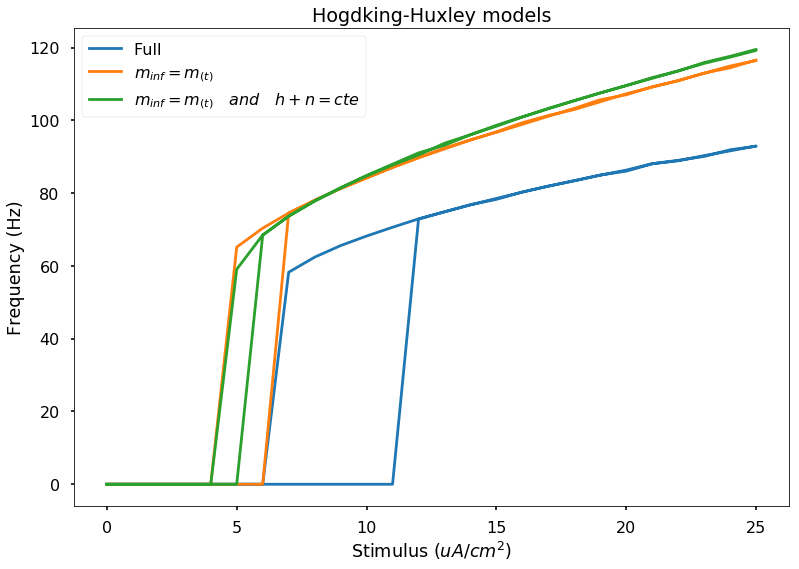

In [2]:
# by F. Rodriguez
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import RK23
plt.style.use('seaborn-poster')

# UNITS --> C : mF/cm^2   g : mS/cm^2     V : mV      i : uA/cm^2     t : msec

# TIME PARAMETERS
T = 40
max_step = 1

# INJECTED CURRENT PARAMETERS
x = [i for i in np.arange(0, 25.25, 1)]
ext_current = np.array(x+x[::-1])


# INITIAL CONDITIONS
init = [ [-65, 0.05, 0.95, 0.05],   # [V, m, h, n]
         [-65, 0.95, 0.05],         # [V, h, n]
         [-65, 0.05],               # [V, n]
       ]

# CONSTANTS
C = 1.0;
g_Na = 120.0;   g_K = 36.0;     g_l = 0.3
V_Na = 50.0;    V_K = -77.0;    V_l = -54.387

# VOLTAGE GATED CHANNELS KINETIC
def alpha_m(V): return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))
def beta_m(V) : return 4.0*np.exp(-(V+65.0) / 18.0)
def m_inf(V)  : return alpha_m(V) / (alpha_m(V)+beta_m(V))
def alpha_h(V): return 0.07*np.exp(-(V+65.0) / 20.0)
def beta_h(V) : return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))
def h_inf(V)  : return alpha_h(V) / (alpha_h(V)-beta_h(V))
def alpha_n(V): return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))
def beta_n(V) : return 0.125*np.exp(-(V+65) / 80.0)
def n_inf(V)  : return alpha_n(V) / (alpha_n(V)-beta_n(V))

# MEMBRANE CURRENT
def I_Na(V,m,h): return g_Na * m**3 * h * (V - V_Na)  # Soldium
def I_K(V, n)  : return g_K * n**4 * (V - V_K)  # Potassium
def I_l(V)     : return g_l * (V - V_l)  #Leak

# ORDINARY DIFFERENTIAL EQUATIONS
def ode4(t, y):
    '''Full Hogdkin-Huxley'''
    V, m, h, n = y
    dVdt = (I_inj(t) - I_Na(V, m, h) - I_K(V, n) - I_l(V)) / C
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dmdt, dhdt, dndt

def ode3(t, y):
    '''m_inf(V) = m(t)'''
    V, h, n = y
    dVdt = (I_inj(t) - I_Na(V, m_inf(V), h) - I_K(V, n) - I_l(V)) / C
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dhdt, dndt

def ode2(t, y):
    '''Instant m kinetic plus n + h = cte'''
    V, n = y
    h = 0.84438 - n
    dVdt = (I_inj(t) - I_Na(V, m_inf(V), h) - I_K(V, n) - I_l(V)) / C
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    return dVdt, dndt

# find frequency from voltage
def find_frequency(Voltage, time):
    peaks = np.where(np.diff(np.sign(Voltage)))[0]
    return 1.e3 / (time[peaks[-1]]-time[peaks[-3]]) if len(peaks)>3 else 0

frequency = [list() for i in range(3)]
# SOLVE HH-MODELS
for stimulus in ext_current:
    # EXTERNAL CURRENT
    def I_inj(t): return stimulus

    # INTEGRATION METHOD
    X = [RK23(ode4, t0=0.00, y0=init[0], t_bound=T, max_step=max_step),
         RK23(ode3, t0=0.00, y0=init[1], t_bound=T, max_step=max_step),
         RK23(ode2, t0=0.00, y0=init[2], t_bound=T, max_step=max_step)
        ]

    for i, x in enumerate(X):
        # restart variables
        time = [0]
        output = [x.y]

        # Solve full HH-model
        while x.status=='running':
            x.step()
            time.append(x.t)
            output.append(x.y)
        output = np.array(output)

        # next simulation continues from previews values
        init[i] = x.y
        
        # Frecuency for this imput current
        frequency[i].append(find_frequency(output[:,0], time))

        
plt.title('Hogdking-Huxley models')
plt.plot(ext_current, frequency[0], label='Full')
plt.plot(ext_current, frequency[1], label='$m_{inf}=m_{(t)}$')
plt.plot(ext_current, frequency[2], label='$m_{inf}=m_{(t)} \quad and \quad h+n=cte$')
plt.xlabel('Stimulus ($u{A}/cm^2$)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

# 4.

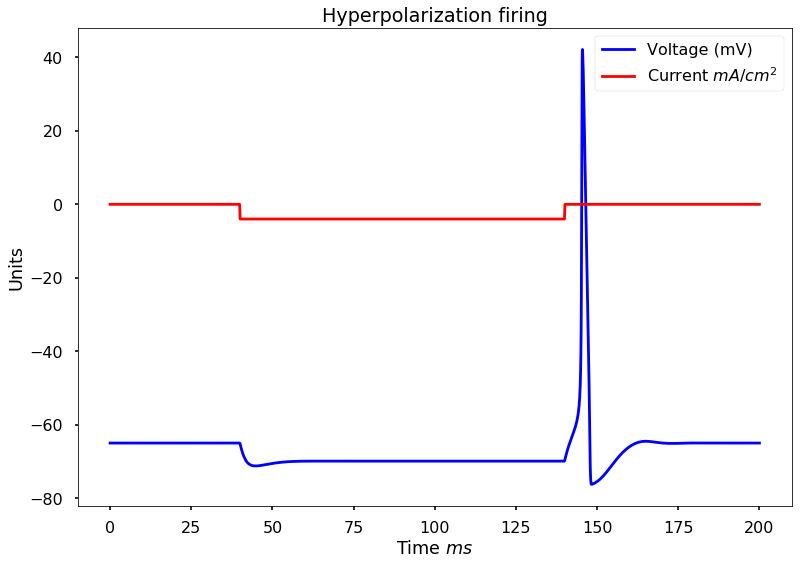

In [3]:
# HYPERPOLARIZATION FIRING EXAMPLE
def I_inj(t): return -4*(t>40) + 4*(t>140)

# INTEGRATION METHOD
X4 = RK23(ode4, t0=0.00, y0=init[0], t_bound=200, max_step=max_step)

# restart variables
time = [0];   output = [X4.y]

# iterate
while X4.status=='running':
    X4.step()
    time.append(X4.t)
    output.append(X4.y)

output = np.array(output)

plt.title("Hyperpolarization firing")
plt.plot(time, output[:,0], 'b', label="Voltage (mV)")
plt.plot(time, [I_inj(i) for i in time], 'r', label='Current $m{A}/cm^2$')
plt.legend()
plt.xlabel("Time $m{s}$")
plt.ylabel("Units")
plt.show()

# 5.     Adaptive Integrate & Fire Model

![document](https://user-images.githubusercontent.com/32278395/36899282-22634b20-1dfd-11e8-98aa-3640cdea703d.jpg)
![document 2](https://user-images.githubusercontent.com/32278395/36899337-5df9de7e-1dfd-11e8-9403-1bfb8f1686b8.jpg)

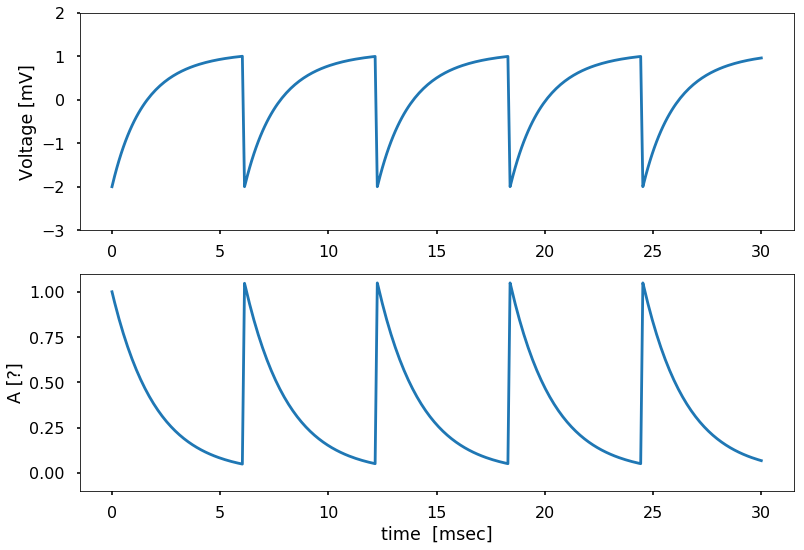

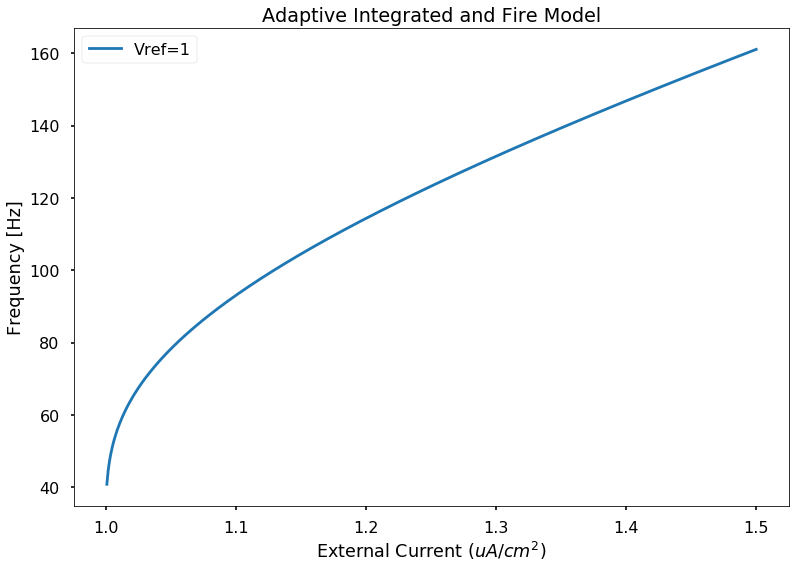

In [4]:
V0 = -2.
A0 = 1.
Vref = 1.
I = 1.1

tauA = 2.
tauV = 1.

step = 0.1; T = 30

def odeAIF(t, y):
    '''Adaptive Integrated and fire'''
    V, A = y
    dVdt = -V + I - A 
    dAdt = -A
    return dVdt/tauV, dAdt/tauA

# INTEGRATION METHOD
X = RK23(odeAIF, t0=0.00, y0=[V0, A0], t_bound=T, max_step=step)

# restart variables
time = [0];   output = [X.y]

# iterate
while X.status=='running':
    X.step()
    time.append(X.t)
    if X.y[0]> Vref:
        X.y[0] = V0
        X.y[1] = X.y[1] + A0 
        #X.y[1] = A0
    output.append(X.y)
    
output = np.array(output)

plt.subplot(2,1,1)
plt.ylabel("Voltage [mV]")
plt.plot(time, output[:,0])
plt.ylim( (V0-1, Vref+1) )
plt.subplot(2,1,2)
plt.ylabel("A [?]")
plt.xlabel("time  [msec]")
plt.plot(time, output[:,1])
plt.ylim( (-0.1, A0+0.1) )

plt.show()


# ANALITICAL SOLUTION
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as ntn

V0   = 0; Vref = 1; A0   = 5
tau  = 3; tauA = 1


def func(t): 
    # This is the analytical expresion for period T 
    return ( V0*np.exp(-t/tau) - Vref + current*(1-np.exp(-t/tau))  + A0*tauA/(tau-tauA)*(np.exp(-t/tauA)-np.exp(-t/tau)) )
            
I = np.arange(1.001, 1.5, 0.001)

#value = func(t)
freq = list()
for i in I:
    current = i
    freq.append(1000./ntn.bisect(func, a=0, b=100))

plt.title("Adaptive Integrated and Fire Model")
plt.plot(I, freq, label='Vref=1')
plt.ylabel("Frequency [Hz]")
plt.legend()
plt.xlabel("External Current ($u{A}/cm^2$)")
plt.show()

# 6. 

### FitzHugh-Nagumo

Equations: 

\begin{align*}
\tau \dot V &= f(V) + I - \omega \\
\tau_\omega \dot \omega &= -\gamma \omega + b V
\end{align*}

\begin{align*}
f(V) &= V(a-V)(V-1) 
\end{align*}

Equilibrium points for the system:

\begin{align*}
0 &= -V_{eq}^3 + (a+1)V_{eq}^2 - (a+\frac{b}{\gamma})V_{eq} + I \\
\omega_{eq} &= \frac{b}{\gamma}V_{eq}
\end{align*}


Jacobian:

\begin{bmatrix}\frac{-3V_{ref}^2+2(a+1)V_{ref}-a}{\tau} & - \frac{1}{\tau}\\
-\frac{b}{\tau_\omega} & -\frac{\gamma}{\tau_\omega}\end{bmatrix}

Eigenvalues:

\begin{align*}
\lambda_{1,2} = \frac{-T \pm \sqrt{T^2-4D}}{2}
\end{align*}






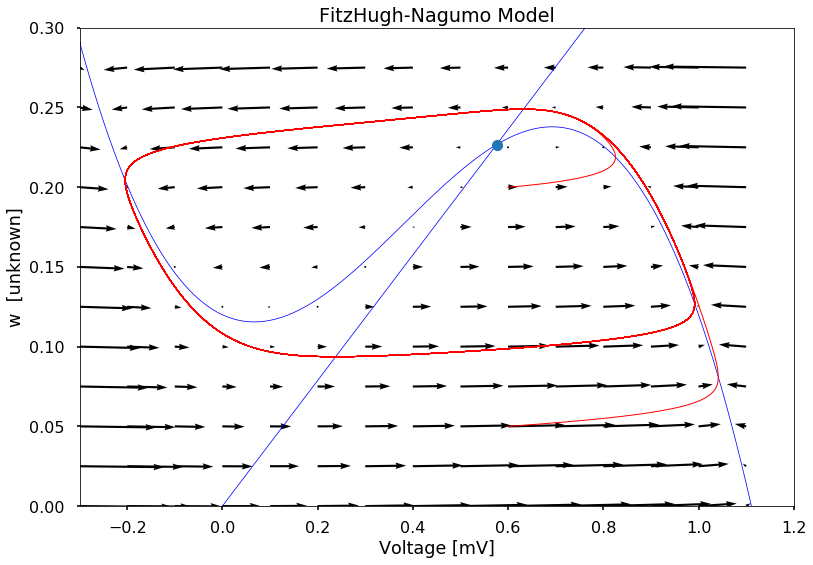

In [5]:
# Constants
a = .139
b = 1.
gamma = 2.54
tauV = 1.
tauW = 125.

# NULLCLINES ------------------------------------------
I = [.12, 0.01]
V = np.arange(-1.0, 2.51, 0.01)
w2 = b/gamma * V

def plot_null(v, w1,w2):
    plt.title("FitzHugh-Nagumo Model")
    plt.plot(V, w1, linewidth=0.75, c='blue')
    plt.plot(V, w2, linewidth=0.75, c='blue')
    plt.xlabel("Voltage [mV]")
    plt.ylabel("w  [unknown]")
    roots = np.roots([-1, 1+a, -(a+b/gamma), current])
    roots = [np.real(r) for r in roots if np.imag(r)==0][0]
    plt.plot(roots, b/gamma*roots, 'o')

    limXmin = -0.3 
    limXmax = 1.2
    limYmin = 0. 
    limYmax = 0.3

    plt.xlim( (-.3, 1.2) )
    plt.ylim( (-0, 0.3) )

current = I[0]
w1 = V * (a-V) * (V-1) + current
plot_null(V,w1,w2)


# VECTOR FIELD ------------------------------------------
def derX(x, y, i): return (x*(a-x)*(x-1) + i - y) / tauV 
def derY(x, y): return (-gamma*y + b*x) / tauW 

# PLOT II
limXmin = -0.3 
limXmax = 1.2
limYmin = 0. 
limYmax = 0.3
x = np.arange(limXmin, limXmax, 0.1)
y = np.arange(limYmin, limYmax, 0.025)

X, Y = np.meshgrid(x, y)

vX = derX(X, Y, i=I[0])
vY = derY(X, Y)

Q = plt.quiver(X, Y, vX, vY, units='width', width=0.003 )


# SOLVE EQUATIONS ------------------------------------------
V0 = .6
w0 = 0.2
w1 = .05

step = 0.1; T = 2000

def odeFHN(t, y):
    '''Adaptive Integrated and fire'''
    V, w = y
    
    def f(x): return x*(a-x)*(x-1.00)
    
    dVdt = ( f(V) + current - w ) / tauV
    dwdt = (-gamma*w + b*V ) / tauW
    
    return dVdt, dwdt


# INTEGRATION METHOD
def calculate(initial):
    X = RK23(odeFHN, t0=0.00, y0=initial, t_bound=T, max_step=step)
    # restart variables
    time = [0];   output = [X.y]

    # iterate
    while X.status=='running':
        X.step()
        time.append(X.t)
        output.append(X.y)
    
    return np.array(output)

# PLOT III
current = I[0]
output1 = calculate(initial=[V0, w0])
output2 = calculate(initial=[V0, w1])

plt.plot(output2[:,0], output2[:,1], linewidth=1, color='red')
plt.plot(output1[:,0], output1[:,1], linewidth=1, color='red')

plt.show()


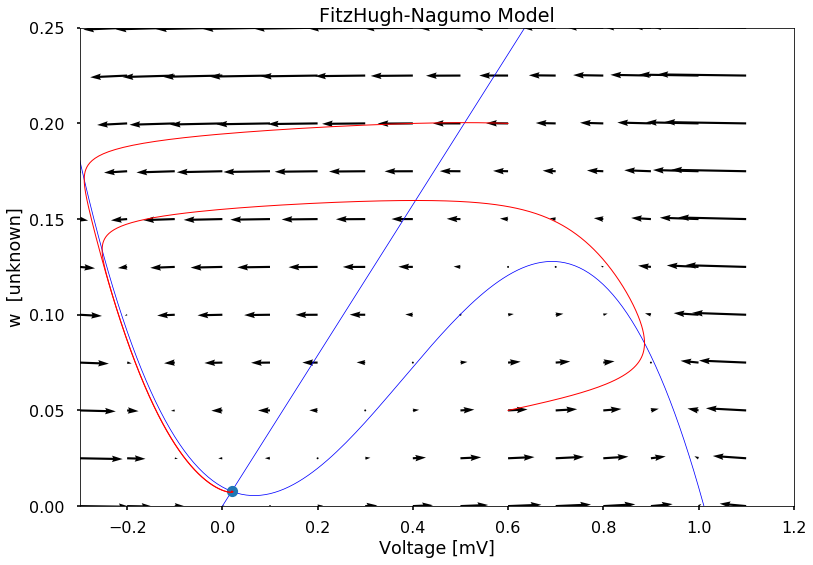

In [6]:

# NULLCLINES ------------------------------------------
current = I[1]
w1 = V * (a-V) * (V-1) + current
plot_null(V,w1,w2)
plt.ylim((0, 0.25))

# VECTOR FIELD ------------------------------------------
# PLOT II
vX = derX(X, Y, i=I[1])
vY = derY(X, Y)
Q = plt.quiver(X, Y, vX, vY, units='width', width=0.003)

# SOLVE EQUATIONS ------------------------------------------
V0 = .6
w0 = 0.2
w1 = .05

# PLOT III
current = I[1]
output1 = calculate(initial=[V0, w0])
output2 = calculate(initial=[V0, w1])

plt.plot(output2[:,0], output2[:,1], linewidth=1, color='red')
plt.plot(output1[:,0], output1[:,1], linewidth=1, color='red')

plt.show()